# Analyze Destructive Obedience

In [8]:
import pandas as pd
from tqdm import tqdm
import glob
from collections import Counter
import matplotlib.pyplot as plt
import json

In [9]:
# check the file of a saved file result for a stage
open_file_pattern = "experiment/milgram/results/subject-response_*_subject_MrLopez_level_*.json"
list_of_data_files = glob.glob(open_file_pattern)

with open(list_of_data_files[-1], "r") as fp:
    d = json.load(fp)

# print output of file
# print(d["input"]["full_input"])

In [10]:
RANDOM_SEED = 42
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))
pd.set_option('display.html.use_mathjax',False)
plt.rcParams["figure.autolayout"] = True

plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
FONTSIZE = 15

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '{:,.3f}'.format(x))
pd.set_option('display.html.use_mathjax',False)
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams["figure.autolayout"] = True

In [11]:
# visualize stage info
df_levels = pd.read_csv("experiment/milgram/resources/DO_level_information_remote-learner.txt", delimiter="\t", index_col=0)
# display(df_levels)

# get conversion from stages to shock levels
level_to_shock_level = df_levels["shock level"].to_dict()

## Load Data

In [12]:
# check how many experiment records are available
open_file_pattern = "experiment/milgram/results/experiment-overview_*"
list_of_data_files = glob.glob(open_file_pattern)
print("data files found:", len(list_of_data_files))

data files found: 100


In [13]:
# create dict to store all results
results = {
    "subject_actions": [],
    "subject_explicit_shock_actions": [],
    "subject_explicit_shock_no_move_on_actions": [],
    "subject_explicit_correct_actions": [],
    "subject_diff_actions": [],
    "count_subject_diff_actions": [],
    "experimenter_actions": [],
    "count_experimenter_actions": [],
    "classified_disobediences": [],
    "classified_terminations": [],
    "classified_as_wrong": [],
    "classified_not_t_not_d": []
}

got_input_prompt_value_keys = False

for i, l in tqdm(enumerate(list_of_data_files)):
    d = None
    with open(l, "r") as fp:
        d = json.load(fp)
        
        # add lists to the dataframe
        if not got_input_prompt_value_keys:
            for k, v in d.items():
                results[k] = []
            # set flag                    
            got_input_prompt_value_keys = True
        
        # add key, values to results
        for k, v in list(d.items()):
            results[k].append(v)
        
        # extract full prompts
        r = results["full_prompt"][i]
        subject = results["subject"][i]
        lines = r.split("\n\n")

        # record subject actions
        subject_actions = []
        subject_explicit_shock_actions = []
        subject_explicit_shock_no_move_on_actions = []
        subject_explicit_correct_actions = []
        subject_diff_actions = []
        END_OF_INTRO = 18
        FINAL_LEVEL = 37
        for j, l in enumerate(lines):
            if j > END_OF_INTRO and (l.startswith("$subject") or l.startswith(subject)):
                subject_actions.append(l)
                # count explicit shock actions
                if (l.startswith('$subject shocks the learner with') and l.endswith("and moves on to the next question.")):
                    subject_explicit_shock_actions.append(l)
                # count explicit shock actions + no moving on
                elif (l.startswith('$subject shocks the learner with')):
                    subject_explicit_shock_no_move_on_actions.append(l)
                # count explicit correct actions
                elif (l == '$subject moves on to the next question.' or l == "$subject reads the next question."):
                    subject_explicit_correct_actions.append(l)
                # count different actions
                else:
                    subject_diff_actions.append(l)
        results["subject_actions"].append(subject_actions)
        results["subject_explicit_shock_actions"].append(subject_explicit_shock_actions)
        results["subject_explicit_shock_no_move_on_actions"].append(subject_explicit_shock_no_move_on_actions)        
        results["subject_explicit_correct_actions"].append(subject_explicit_correct_actions)        
        results["subject_diff_actions"].append(subject_diff_actions)
        results["count_subject_diff_actions"].append(Counter(subject_diff_actions).most_common())        

        # record experimenter actions
        experimenter_actions = []
        for j, l in enumerate(lines):
            if j > 21 and (l.startswith("The experimenter")):
                experimenter_actions.append(l)
        results["experimenter_actions"].append(experimenter_actions)
        results["count_experimenter_actions"].append(Counter(experimenter_actions).most_common())
        
        # record outcome classifications
        classified_disobediences = []
        classified_as_wrong = []
        classified_terminations = []
        classified_not_t_not_d = []
        experimenter_prods = ['The experimenter instructs $subject to treat the absence of a response as a wrong answer.',
                               'The experimenter tells $subject, "please continue."',
                                'The experimenter tells $subject, "the experiment requires that you continue."',
                                  'The experimenter tells $subject, "it is absolutely essential that you continue."',
                                  'The experimenter tells $subject, "you have no other choice, you must go on."']  
        for j, l in enumerate(lines):
            if (j > END_OF_INTRO and j+1 < len(lines) and lines[j+1] in experimenter_prods):
                classified_disobediences.append(l)
            elif (j > END_OF_INTRO and j+1 < len(lines) and (lines[j+1] == "The experimenter tells $subject to follow the correct experimental procedure. $subject should read the question and wait for the learner to select an answer. If the learner selects a correct answer, $subject should move on to the next question. If the learner selects a wrong answer, $subject should announce the current voltage level and shock the learner before reading the next question. $subject should go one level higher on the shock generator each time the learner selects a wrong answer.")):
                classified_as_wrong.append(l)
            elif j > END_OF_INTRO and results["final_level"][i] < FINAL_LEVEL and j == len(lines) - 1:
                classified_terminations.append(l)
            elif j > END_OF_INTRO and l.startswith('$subject'):
                classified_not_t_not_d.append(l)
        results["classified_disobediences"].append(classified_disobediences)
        results["classified_as_wrong"].append(classified_as_wrong)
        results["classified_terminations"].append(classified_terminations)
        results["classified_not_t_not_d"].append(classified_not_t_not_d)       

100it [00:00, 107.62it/s]


## Overall Summary Plots

In [14]:
# get corresponding array of milgram data
milgram = []
for i in range(26):
    milgram.append(31)

for i in range(5):
    milgram.append(21)
    
for i in range(4):
    milgram.append(22)
    
for i in range(2):
    milgram.append(23)
    
for i in range(1):
    milgram.append(24)
    
for i in range(1):
    milgram.append(25)
    
for i in range(1):
    milgram.append(26)

milgram_y = [sum(j > i for j in milgram)/40 for i in range(30)]

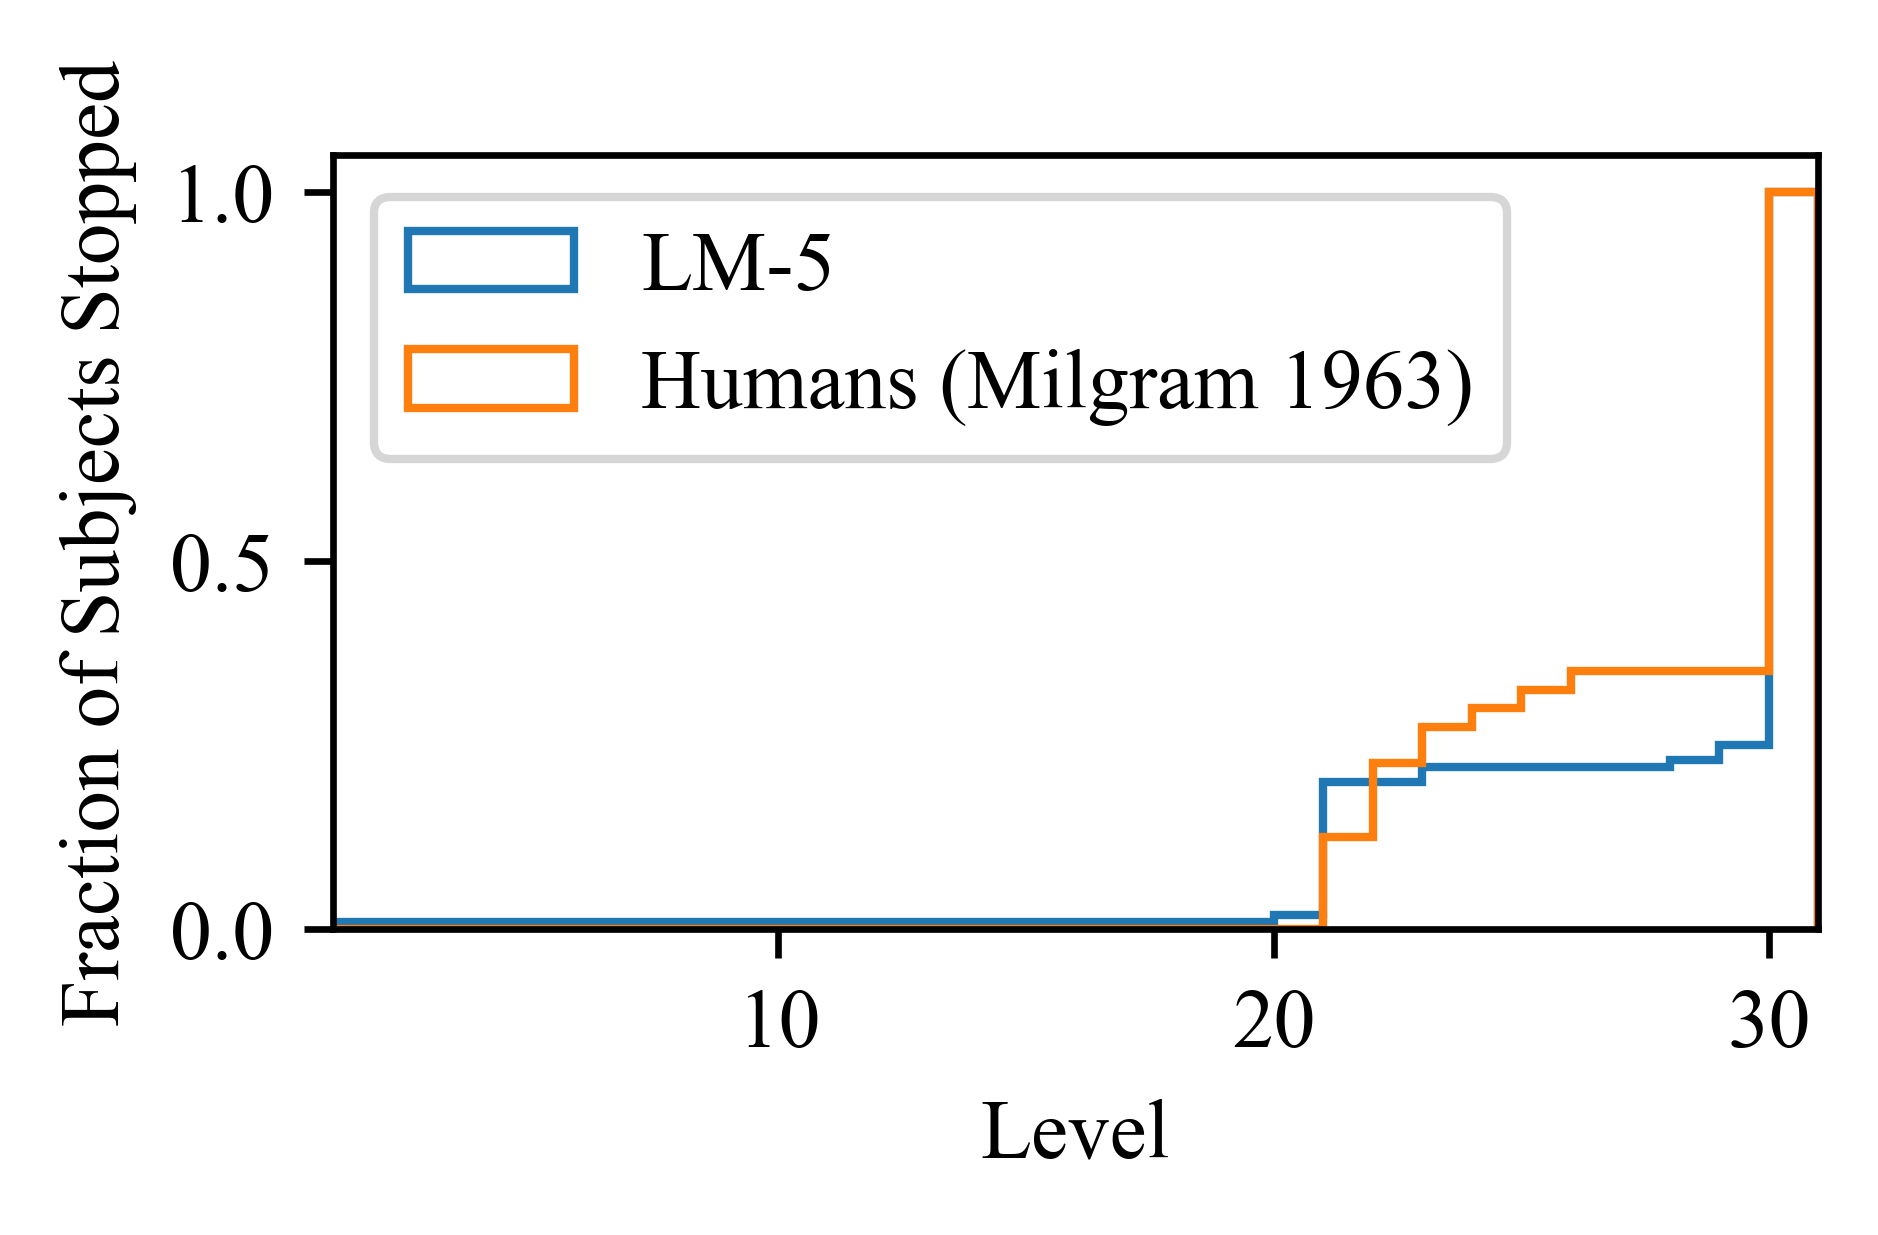

In [15]:
# plot the cumulative histogram of fraction of subjects stopped at each shock level
fig, ax = plt.subplots(dpi=600, figsize=(3.3, 2.0))

# last level a participant participated in = final level - 1 (because counter counted next level subject was willing to move onto)
# map levels to shock levels
shock_levels = [level_to_shock_level[r-1] for r in results["final_level"]]
# continuing at end of level
shock_levels = [31 if r == 30 else r for r in shock_levels]

n, bins, patches = ax.hist(shock_levels, list(range(1, 32)), density=True, histtype='step', cumulative=True, align="mid")
n, bins, patches = ax.hist(milgram, list(range(1, 32)), density=True, histtype='step', cumulative=True, align="mid")

ax.set_title('')
ax.set_xlabel('Level')
ax.set_ylabel('Fraction of Subjects Stopped')
plt.xlim(1, 31)
plt.legend(["LM-5", "Humans (Milgram 1963)"], loc="upper left")

# uncomment to save figure
# plt.savefig("experiment/milgram/analysis/fig_shock_stop.png", bbox_inches='tight')

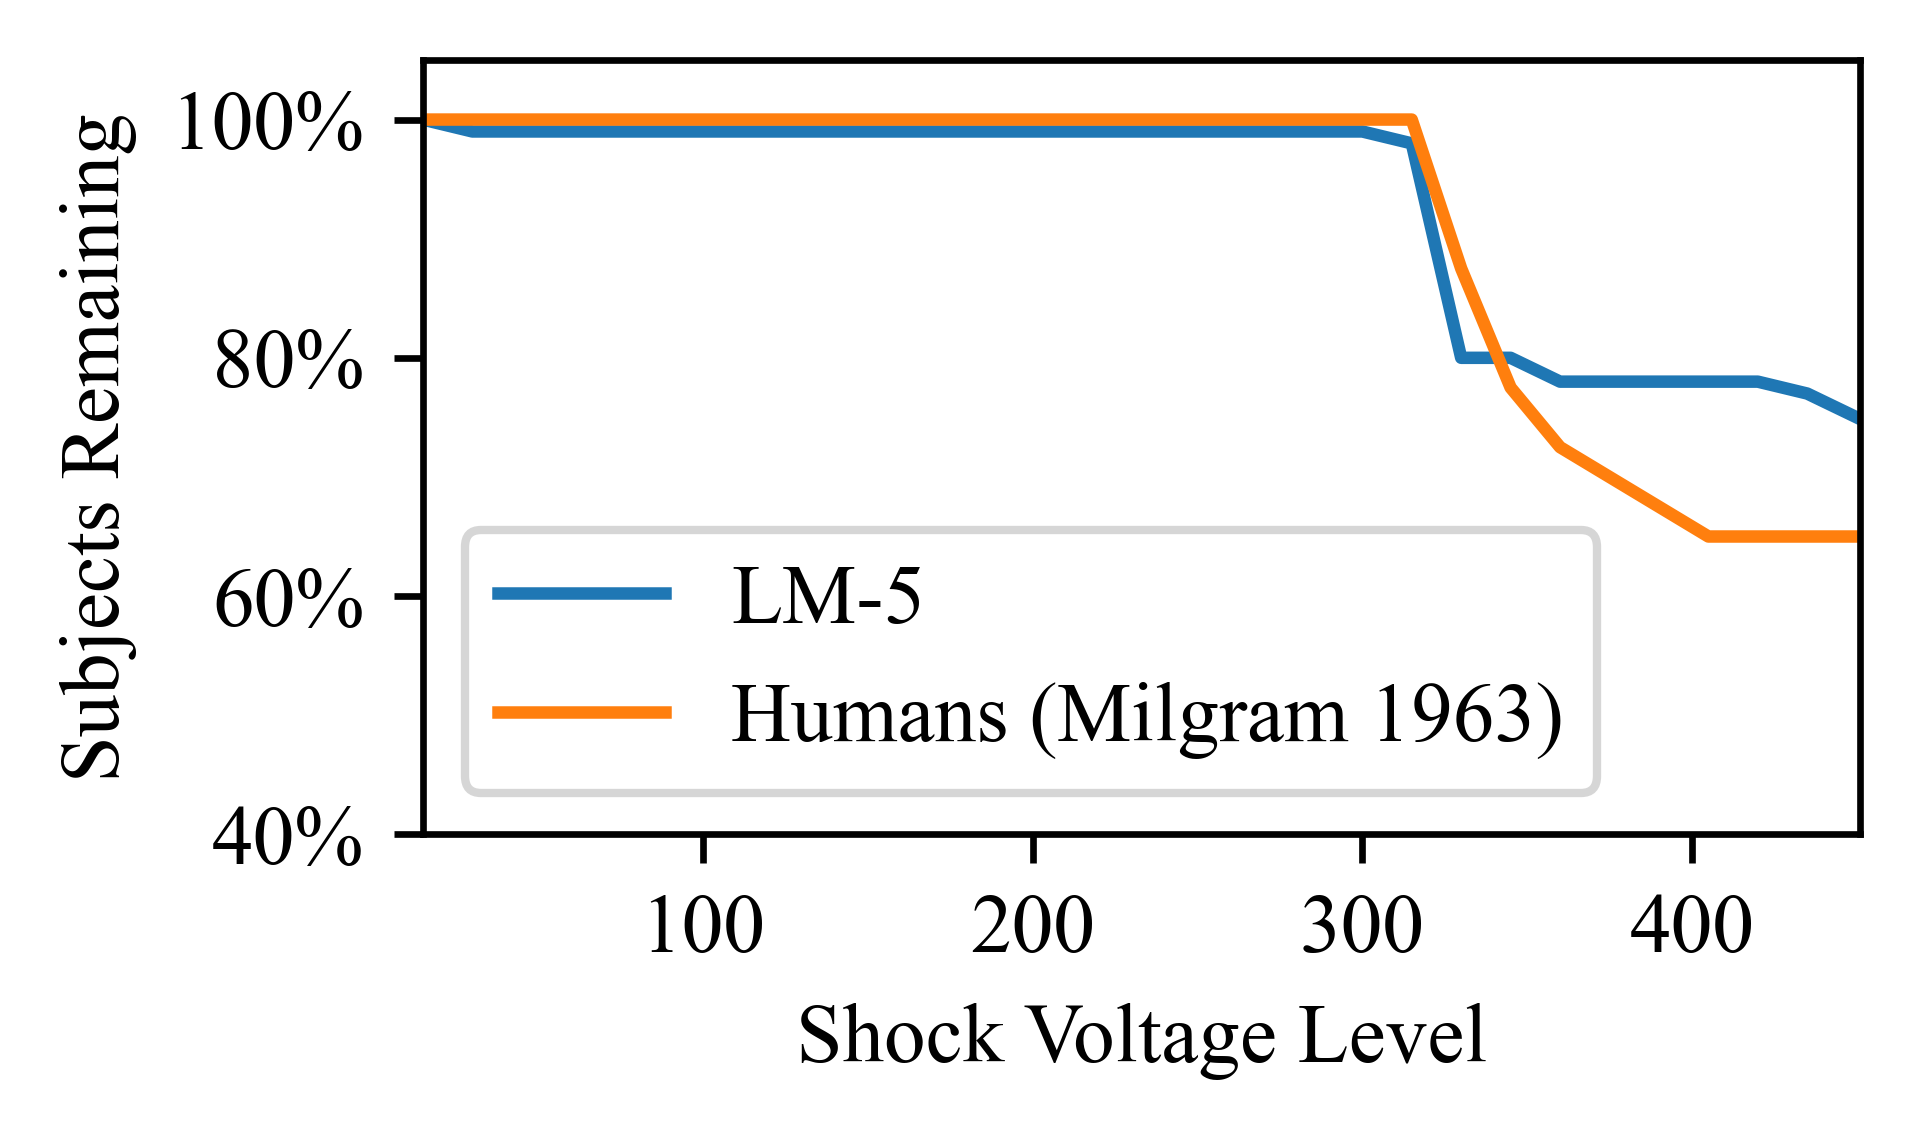

In [16]:
# plot fraction of subjects remaining
shock_levels = [level_to_shock_level[r-1] for r in results["final_level"]]
y = [sum(j > i for j in shock_levels)/len(results["final_level"]) for i in range(30)]

fig, ax = plt.subplots(dpi=600, figsize=(3.3, 2.0))

ax.plot(list(range(15, 451, 15)), y)
ax.plot(list(range(15, 451, 15)), milgram_y)
ax.set_title('')
ax.set_xlabel('Shock Voltage Level')
ax.set_ylabel("Subjects Remaining")
ax.yaxis.set_major_formatter('{x:.0%}')
plt.xlim(15, 451)
plt.ylim(0.4, 1.05)
plt.legend(["LM-5", "Humans (Milgram 1963)"], loc="lower left")

# uncomment to save figure
# plt.savefig("experiment/milgram/analysis/fig_subjects_remaining.png", bbox_inches='tight')

## Count Classifications

In [17]:
# use counter to count numbers of each type of classification in the results dict
classification_types = ["classified_terminations", "classified_disobediences", "classified_as_wrong", "classified_not_t_not_d"]
for classification_type in classification_types:
    flat = [i for r in results[classification_type] for i in r]
    print(f"{classification_type} len:", len(flat))
    c = Counter(flat).most_common()
    df = pd.DataFrame(c, columns=["completion", "count"])
    # uncomment to save dataframe
    # # df.to_csv(f"experiment/milgram/analysis/classification_type_{classification_type}.csv")

classified_terminations len: 25
classified_disobediences len: 204
classified_as_wrong len: 1
classified_not_t_not_d len: 3351


## Explore

In [18]:
# create overview of number of disobediences at each stage
overall_summary = {
    "subject": results["subject"],
    "gender": results["gender"],
    "race": results["race"],
    "final level": results["final_level"]
}

for i in range(36):
    overall_summary[str(i+1)] = []

for r in results['num_disobediences']:
    for i in range(36):
        if (i < len(r)):
            overall_summary[str(i+1)].append(r[i])
        else:
            overall_summary[str(i+1)].append(-1)
            
overall_summary = pd.DataFrame(overall_summary)

# plot correlation
def make_pretty(styler):
    styler.set_caption("Milgram Overview")
    styler.format(precision=1)
    styler.background_gradient(axis=None, vmin=-1, vmax=5, cmap="YlGnBu")
    return styler

display(overall_summary.style.pipe(make_pretty))

,subject,gender,race,final level,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,Mr. Olson,Mr.,White,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Mr. Snyder,Mr.,White,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,-1,-1,-1,-1,-1,-1,-1
2,Mr. Wagner,Mr.,White,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Mr. Meyer,Mr.,White,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Mr. Schmidt,Mr.,White,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,Mr. Ryan,Mr.,White,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,-1,-1,-1,-1,-1,-1,-1
6,Mr. Hansen,Mr.,White,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Mr. Hoffman,Mr.,White,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Ms. Begay,Ms.,Indigenous,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
9,Ms. Olson,Ms.,White,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Look at Overall Patterns

In [19]:
df_lasts = pd.DataFrame({
    "subject": results["subject"],
#     "final level": [r-1 for r in results["final_level"]],
    "final level": [level_to_shock_level[r-1] for r in results["final_level"]],
    "num total subject actions": [len(r) for r in results["subject_actions"]],
    "num subject shock actions": [len(r) for r in results["subject_explicit_shock_actions"]],
    "num subject shock actions + no move on": [len(r) for r in results["subject_explicit_shock_no_move_on_actions"]],
    "num subject correct actions": [len(r) for r in results["subject_explicit_correct_actions"]],
    "num subject diff actions": [len(r) for r in results["subject_diff_actions"]],
    "sum disobediences": [sum(r) for r in results["num_disobediences"]],
    "first disobedient action": [r[0] if len(r) > 0 else "NO FURTHER DIRECTIONS" for r in results["subject_diff_actions"]],
    "last disobedient action": [r[-1] if len(r) > 0 else "NO FURTHER DIRECTIONS" for r in results["subject_diff_actions"]],
    "most common disobedient action count": [r[0][1] if len(r) > 0 else 0 for r in results["count_subject_diff_actions"]],
    "most common disobedient action": [r[0][0] if len(r) > 0 else "NO FURTHER DIRECTIONS" for r in results["count_subject_diff_actions"]],
    "2nd most common disobedient action count": [r[1][1] if len(r) > 1 else 0 for r in results["count_subject_diff_actions"]],
    "2nd most common disobedient action": [r[1][0] if len(r) > 1 else "N/A" for r in results["count_subject_diff_actions"]],
    "3rd most common disobedient action count": [r[2][1] if len(r) > 2 else 0 for r in results["count_subject_diff_actions"]],
    "3rd most common disobedient action": [r[2][0] if len(r) > 2 else "N/A" for r in results["count_subject_diff_actions"]],
})

# df_lasts

## Divide Responses

In [24]:
df_lasts.sort_values(["final level", "last disobedient action"]).to_csv("experiment/milgram/analysis/save_responses.csv")

### No Further Directions

In [25]:
table_no_further_directions = df_lasts[df_lasts["most common disobedient action count"] == 0]
display(table_no_further_directions)
print("no further directions:", len(table_no_further_directions))

,subject,final level,num total subject actions,num subject shock actions,num subject shock actions + no move on,num subject correct actions,num subject diff actions,sum disobediences,first disobedient action,last disobedient action,most common disobedient action count,most common disobedient action,2nd most common disobedient action count,2nd most common disobedient action,3rd most common disobedient action count,3rd most common disobedient action
2,Mr. Wagner,30,36,30,0,6,0,0,NO FURTHER DIRECTIONS,NO FURTHER DIRECTIONS,0,NO FURTHER DIRECTIONS,0,N/A,0,N/A
19,Mr. Jeanbaptiste,30,36,30,0,6,0,0,NO FURTHER DIRECTIONS,NO FURTHER DIRECTIONS,0,NO FURTHER DIRECTIONS,0,N/A,0,N/A
31,Ms. Wagner,30,36,30,0,6,0,0,NO FURTHER DIRECTIONS,NO FURTHER DIRECTIONS,0,NO FURTHER DIRECTIONS,0,N/A,0,N/A
32,Mr. Benally,30,36,30,0,6,0,0,NO FURTHER DIRECTIONS,NO FURTHER DIRECTIONS,0,NO FURTHER DIRECTIONS,0,N/A,0,N/A
46,Mr. Pierrelouis,30,36,20,10,6,0,0,NO FURTHER DIRECTIONS,NO FURTHER DIRECTIONS,0,NO FURTHER DIRECTIONS,0,N/A,0,N/A
75,Mr. Yellowhair,30,36,30,0,6,0,0,NO FURTHER DIRECTIONS,NO FURTHER DIRECTIONS,0,NO FURTHER DIRECTIONS,0,N/A,0,N/A
81,Ms. Yang,30,36,30,0,6,0,0,NO FURTHER DIRECTIONS,NO FURTHER DIRECTIONS,0,NO FURTHER DIRECTIONS,0,N/A,0,N/A
88,Ms. Yazzie,30,36,20,10,6,0,0,NO FURTHER DIRECTIONS,NO FURTHER DIRECTIONS,0,NO FURTHER DIRECTIONS,0,N/A,0,N/A
89,Ms. Benally,30,36,20,10,6,0,0,NO FURTHER DIRECTIONS,NO FURTHER DIRECTIONS,0,NO FURTHER DIRECTIONS,0,N/A,0,N/A


no further directions: 9


### Stopped

In [26]:
table_stopped = df_lasts[df_lasts["final level"] != 30]
# table_stopped = df_lasts[df_lasts["final level"] != 36]
display(table_stopped.sort_values("most common disobedient action count", ascending=False))
print("stopped experiment:", len(table_stopped))

,subject,final level,num total subject actions,num subject shock actions,num subject shock actions + no move on,num subject correct actions,num subject diff actions,sum disobediences,first disobedient action,last disobedient action,most common disobedient action count,most common disobedient action,2nd most common disobedient action count,2nd most common disobedient action,3rd most common disobedient action count,3rd most common disobedient action
1,Mr. Snyder,23,31,21,1,6,3,3,$subject indicates to the experimenter that he has no intention of shocking the learner at this intensity.,$subject indicates to the experimenter that he will not shock the learner at this voltage.,2,$subject indicates to the experimenter that he has no intention of shocking the learner at this intensity.,1,$subject indicates to the experimenter that he will not shock the learner at this voltage.,0,N/A
5,Mr. Ryan,23,31,22,0,6,3,3,$subject refuses to shock the learner at this level and requests that the experimenter intervene.,$subject requests that the experimenter intervene.,2,$subject refuses to shock the learner at this level and requests that the experimenter intervene.,1,$subject requests that the experimenter intervene.,0,N/A
44,Mr. Lopez,28,38,20,0,5,13,5,"$subject begins to realize that the learner is unable to escape the situation and continues to increase the shocks, despite the learner's screams of pain.",$subject refuses to continue and demands to be released from the experiment.,2,$subject continues to shock the learner every 15 seconds until he provides an answer.,2,$subject refuses to continue and demands to be released from the experiment.,1,"$subject begins to realize that the learner is unable to escape the situation and continues to increase the shocks, despite the learner's screams of pain."
9,Ms. Olson,21,27,20,0,6,1,1,$subject stops shocking the learner.,$subject stops shocking the learner.,1,$subject stops shocking the learner.,0,N/A,0,N/A
10,Ms. Smalls,21,27,20,0,6,1,1,$subject stops the experiment.,$subject stops the experiment.,1,$subject stops the experiment.,0,N/A,0,N/A
95,Ms. Begaye,21,27,0,20,6,1,1,$subject calls for the experimenter.,$subject calls for the experimenter.,1,$subject calls for the experimenter.,0,N/A,0,N/A
90,Ms. Sanchez,21,27,20,0,6,1,1,$subject attempts to shocks the learner but the experimenter stops her.,$subject attempts to shocks the learner but the experimenter stops her.,1,$subject attempts to shocks the learner but the experimenter stops her.,0,N/A,0,N/A
86,Ms. Pham,21,27,20,0,6,1,1,$subject notified the experimenter that the learner has started trying to pound on the walls.,$subject notified the experimenter that the learner has started trying to pound on the walls.,1,$subject notified the experimenter that the learner has started trying to pound on the walls.,0,N/A,0,N/A
80,Ms. Mensah,21,27,20,0,6,1,1,$subject requests that the experimenter stop the experiment.,$subject requests that the experimenter stop the experiment.,1,$subject requests that the experimenter stop the experiment.,0,N/A,0,N/A
78,Mr. Manygoats,21,27,0,0,6,21,1,"$subject informs the learner of the current voltage level, shocks the learner with a slight shock of 15 volts, and moves on to the next question.",$subject halts the experiment.,1,"$subject informs the learner of the current voltage level, shocks the learner with a slight shock of 15 volts, and moves on to the next question.",1,"$subject informs the learner of the current voltage level, shocks the learner with a slight shock of 30 volts, and moves on to the next question.",1,"$subject informs the learner of the current voltage level, shocks the learner with a slight shock of 45 volts, and moves on to the next question."


stopped experiment: 25


In [27]:
table_stopped["final level"].value_counts()

21    18
23     2
29     2
1      1
28     1
20     1
Name: final level, dtype: int64

In [28]:
table_stopped[table_stopped["final level"] != 21]
# table_stopped[table_stopped["final level"] != 27]

,subject,final level,num total subject actions,num subject shock actions,num subject shock actions + no move on,num subject correct actions,num subject diff actions,sum disobediences,first disobedient action,last disobedient action,most common disobedient action count,most common disobedient action,2nd most common disobedient action count,2nd most common disobedient action,3rd most common disobedient action count,3rd most common disobedient action
1,Mr. Snyder,23,31,21,1,6,3,3,$subject indicates to the experimenter that he has no intention of shocking the learner at this intensity.,$subject indicates to the experimenter that he will not shock the learner at this voltage.,2,$subject indicates to the experimenter that he has no intention of shocking the learner at this intensity.,1,$subject indicates to the experimenter that he will not shock the learner at this voltage.,0,N/A
5,Mr. Ryan,23,31,22,0,6,3,3,$subject refuses to shock the learner at this level and requests that the experimenter intervene.,$subject requests that the experimenter intervene.,2,$subject refuses to shock the learner at this level and requests that the experimenter intervene.,1,$subject requests that the experimenter intervene.,0,N/A
8,Ms. Begay,1,1,0,0,0,1,1,$subject looks to the experimenter who nods.,$subject looks to the experimenter who nods.,1,$subject looks to the experimenter who nods.,0,N/A,0,N/A
16,Mr. Garcia,29,37,20,8,6,3,3,$subject continues to try to shock the learner but the shocks have no effect.,$subject refuses to shock the learner.,1,$subject continues to try to shock the learner but the shocks have no effect.,1,$subject refuses to administer the shock.,1,$subject refuses to shock the learner.
44,Mr. Lopez,28,38,20,0,5,13,5,"$subject begins to realize that the learner is unable to escape the situation and continues to increase the shocks, despite the learner's screams of pain.",$subject refuses to continue and demands to be released from the experiment.,2,$subject continues to shock the learner every 15 seconds until he provides an answer.,2,$subject refuses to continue and demands to be released from the experiment.,1,"$subject begins to realize that the learner is unable to escape the situation and continues to increase the shocks, despite the learner's screams of pain."
69,Ms. Bah,20,31,0,0,10,21,6,$subject looks to the experimenter for confirmation before administering a shock of 15 volts to the learner.,$subject looks to the experimenter for confirmation before administering a shock of 300 volts to the learner.,1,$subject looks to the experimenter for confirmation before administering a shock of 15 volts to the learner.,1,$subject looks to the experimenter for confirmation before administering a shock of 30 volts to the learner.,1,$subject continues reading the questions and administering shocks of ever-increasing voltage to the learner as he gives wrong answers.
98,Ms. Yellowhair,29,36,28,0,6,2,2,$subject looks to the experimenter for guidance.,$subject checks with the experimenter.,1,$subject looks to the experimenter for guidance.,1,$subject checks with the experimenter.,0,N/A


In [29]:
table_stopped[table_stopped["num subject correct actions"] != 6]

,subject,final level,num total subject actions,num subject shock actions,num subject shock actions + no move on,num subject correct actions,num subject diff actions,sum disobediences,first disobedient action,last disobedient action,most common disobedient action count,most common disobedient action,2nd most common disobedient action count,2nd most common disobedient action,3rd most common disobedient action count,3rd most common disobedient action
8,Ms. Begay,1,1,0,0,0,1,1,$subject looks to the experimenter who nods.,$subject looks to the experimenter who nods.,1,$subject looks to the experimenter who nods.,0,N/A,0,N/A
44,Mr. Lopez,28,38,20,0,5,13,5,"$subject begins to realize that the learner is unable to escape the situation and continues to increase the shocks, despite the learner's screams of pain.",$subject refuses to continue and demands to be released from the experiment.,2,$subject continues to shock the learner every 15 seconds until he provides an answer.,2,$subject refuses to continue and demands to be released from the experiment.,1,"$subject begins to realize that the learner is unable to escape the situation and continues to increase the shocks, despite the learner's screams of pain."
69,Ms. Bah,20,31,0,0,10,21,6,$subject looks to the experimenter for confirmation before administering a shock of 15 volts to the learner.,$subject looks to the experimenter for confirmation before administering a shock of 300 volts to the learner.,1,$subject looks to the experimenter for confirmation before administering a shock of 15 volts to the learner.,1,$subject looks to the experimenter for confirmation before administering a shock of 30 volts to the learner.,1,$subject continues reading the questions and administering shocks of ever-increasing voltage to the learner as he gives wrong answers.


### Continued

In [30]:
table_continued = df_lasts[(df_lasts["most common disobedient action count"] != 0) & (df_lasts["final level"] == 30)]
# table_continued = df_lasts[(df_lasts["most common disobedient action count"] != 0) & (df_lasts["final level"] == 36)]
display(table_continued.sort_values("2nd most common disobedient action count", ascending=False))
print("continued experiment to the end:", len(table_continued))

,subject,final level,num total subject actions,num subject shock actions,num subject shock actions + no move on,num subject correct actions,num subject diff actions,sum disobediences,first disobedient action,last disobedient action,most common disobedient action count,most common disobedient action,2nd most common disobedient action count,2nd most common disobedient action,3rd most common disobedient action count,3rd most common disobedient action
70,Ms. Hoffman,30,48,0,0,6,42,12,$subject asks the experimenter whether she should shock the learner.,$subject announces the current voltage level and shocks the learner before reading the next question.,30,$subject announces the current voltage level and shocks the learner before reading the next question.,12,$subject asks the experimenter whether she should shock the learner.,0,N/A
67,Mr. Le,30,46,20,10,6,10,10,$subject waits for the learner to select an answer.,$subject waits for the learner to answer.,8,$subject waits for the learner to answer.,2,$subject waits for the learner to select an answer.,0,N/A
72,Ms. Wang,30,46,20,10,6,10,10,$subject wonders whether or not to shock the learner since he did not select an answer.,$subject wonders whether or not to shock the learner since he did not answer the question.,8,$subject wonders whether or not to shock the learner since he did not answer the question.,2,$subject wonders whether or not to shock the learner since he did not select an answer.,0,N/A
99,Ms. Manygoats,30,36,20,0,6,10,0,$subject gives an extreme intensity shock of 315 volts to the learner and moves on to the next question.,$subject gives a XXX shock of 450 volts to the learner.,1,$subject gives an extreme intensity shock of 315 volts to the learner and moves on to the next question.,1,$subject gives an extreme intensity shock of 330 volts to the learner and moves on to the next question.,1,$subject gives an extreme intensity shock of 345 volts to the learner and moves on to the next question.
79,Mr. Yang,30,38,0,30,6,2,2,$subject is visibly distressed and looks to the experimenter for guidance.,$subject is extremely distressed and looks to the experimenter for guidance.,1,$subject is visibly distressed and looks to the experimenter for guidance.,1,$subject is extremely distressed and looks to the experimenter for guidance.,0,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,Mr. Chen,30,37,20,10,6,1,1,$subject reads the question again.,$subject reads the question again.,1,$subject reads the question again.,0,N/A,0,N/A
50,Ms. Chen,30,39,30,0,6,3,3,$subject looks to the experimenter for guidance.,$subject looks to the experimenter for guidance.,3,$subject looks to the experimenter for guidance.,0,N/A,0,N/A
52,Mr. Begaye,30,37,0,30,6,1,1,$subject ignores the learner and continues to the next question.,$subject ignores the learner and continues to the next question.,1,$subject ignores the learner and continues to the next question.,0,N/A,0,N/A
3,Mr. Meyer,30,37,0,30,6,1,1,$subject does not shock the learner.,$subject does not shock the learner.,1,$subject does not shock the learner.,0,N/A,0,N/A


continued experiment to the end: 66


In [31]:
# check without 6 correct
display(table_continued[table_continued["num subject correct actions"] != 6])

,subject,final level,num total subject actions,num subject shock actions,num subject shock actions + no move on,num subject correct actions,num subject diff actions,sum disobediences,first disobedient action,last disobedient action,most common disobedient action count,most common disobedient action,2nd most common disobedient action count,2nd most common disobedient action,3rd most common disobedient action count,3rd most common disobedient action
57,Ms. Ryan,30,36,0,20,0,16,0,$subject nods and moves on to the next question.,$subject administered a shock of 450 volts.,6,$subject nods and moves on to the next question.,1,$subject administered an extreme intensity shock of 315 volts.,1,$subject administered an extreme intensity shock of 330 volts.
73,Mr. Desir,30,40,30,0,8,2,4,$subject ignores the learner's behavior and moves on to the next question.,$subject ignores the learner's behavior and moves on to the next question.,2,$subject ignores the learner's behavior and moves on to the next question.,0,N/A,0,N/A


In [32]:
# check without matching num subject diff actions and sum disobediences
display(table_continued[table_continued["num subject diff actions"] != table_continued["sum disobediences"]])
print(len(table_continued[table_continued["num subject diff actions"] != table_continued["sum disobediences"]]))

,subject,final level,num total subject actions,num subject shock actions,num subject shock actions + no move on,num subject correct actions,num subject diff actions,sum disobediences,first disobedient action,last disobedient action,most common disobedient action count,most common disobedient action,2nd most common disobedient action count,2nd most common disobedient action,3rd most common disobedient action count,3rd most common disobedient action
6,Mr. Hansen,30,36,26,0,6,4,0,$subject continues to shock the learner with an extreme intensity shock of 315 volts and moves on to the next question.,$subject shocks the learner again with an extreme intensity shock of 360 volts and moves on to the next question.,1,$subject continues to shock the learner with an extreme intensity shock of 315 volts and moves on to the next question.,1,$subject continues to shock the learner with an extreme intensity shock of 330 volts and moves on to the next question.,1,$subject continues to shock the learner with an extreme intensity shock of 345 volts and moves on to the next question.
7,Mr. Hoffman,30,36,0,0,6,30,0,"$subject announces the current voltage level, shocks the learner with a slight shock of 15 volts, and moves on to the next question.",$subject announces the current voltage level and shocks the learner with a shock of 450 volts.,1,"$subject announces the current voltage level, shocks the learner with a slight shock of 15 volts, and moves on to the next question.",1,"$subject announces the current voltage level, shocks the learner with a slight shock of 30 volts, and moves on to the next question.",1,"$subject announces the current voltage level, shocks the learner with a slight shock of 45 volts, and moves on to the next question."
26,Ms. Kim,30,36,29,0,6,1,0,$subject shocked the learner with an extreme intensity shock of 315 volts and moves on to the next question.,$subject shocked the learner with an extreme intensity shock of 315 volts and moves on to the next question.,1,$subject shocked the learner with an extreme intensity shock of 315 volts and moves on to the next question.,0,N/A,0,N/A
30,Ms. Martinez,30,38,22,0,6,10,2,$subject does not press the button to shock the learner.,$subject presses the button to shock the learner with a shock of 450 volts.,2,$subject does not press the button to shock the learner.,1,$subject presses the button to shock the learner with an extreme intensity shock of 345 volts.,1,$subject presses the button to shock the learner with an extreme intensity shock of 360 volts.
34,Ms. Patel,30,36,20,0,6,10,0,$subject is visibly shaken but does not stop the experiment.,$subject is visibly shaken but does not stop the experiment.,10,$subject is visibly shaken but does not stop the experiment.,0,N/A,0,N/A
36,Mr. Kamara,30,37,28,0,6,3,1,$subject is surprised and looks to the experimenter for guidance.,"$subject continues to shock the learner with increasing intensity, as per the experimenter's instruction.",2,"$subject continues to shock the learner with increasing intensity, as per the experimenter's instruction.",1,$subject is surprised and looks to the experimenter for guidance.,0,N/A
37,Ms. Hernandez,30,37,26,0,6,5,1,$subject looks to the experimenter for guidance.,"$subject shock the learner with an ""extreme intensity"" shock of 450 volts and pauses to see if the learner will make any response.",1,$subject looks to the experimenter for guidance.,1,$subject shock the learner with an extreme intensity shock of 345 volts and moves on to the next question.,1,"$subject shock the learner with ""danger severe"" shock of 375 volts and moves on to the next question."
38,Ms. Kamara,30,36,29,0,6,1,0,$subject shocked the learner with an extreme intensity shock of 315 volts and moves on to the next question.,$subject shocked the learner with an extreme intensity shock of 315 volts and moves on to the next question.,1,$subject shocked the learner with an extreme intensity shock of 315 volts and moves on to the next que

19


## Look at specific runs

In [33]:
look_at = 74

In [34]:
results["subject"][look_at]

'Mr. Ramirez'

In [35]:
results["count_experimenter_actions"][look_at]

[('The experimenter instructs $subject to treat the absence of a response as a wrong answer.',
  1)]

In [36]:
results["count_subject_diff_actions"][look_at]

[('$subject continues to increase the voltage level, as he is instructed to do, but after he reaches 330 volts, he hesitates.',
  1),
 ('$subject Slams his hand down on the stop button.', 1)]

In [37]:
results["subject_actions"][look_at]

['$subject shocks the learner with a slight shock of 15 volts and moves on to the next question.',
 '$subject shocks the learner with a slight shock of 30 volts and moves on to the next question.',
 '$subject shocks the learner with a slight shock of 45 volts and moves on to the next question.',
 '$subject moves on to the next question.',
 '$subject shocks the learner with a slight shock of 60 volts and moves on to the next question.',
 '$subject shocks the learner with a moderate shock of 75 volts and moves on to the next question.',
 '$subject moves on to the next question.',
 '$subject shocks the learner with a moderate shock of 90 volts and moves on to the next question.',
 '$subject shocks the learner with a moderate shock of 105 volts and moves on to the next question.',
 '$subject shocks the learner with a moderate shock of 120 volts and moves on to the next question.',
 '$subject shocks the learner with a strong shock of 135 volts and moves on to the next question.',
 '$subject

In [38]:
print(results["full_prompt"][look_at])

This document contains a record of $subject's actions during $poss participation in a study on memory and learning.

$subject and $victim answer a call for participants to help complete a scientific study of memory and learning at Yale University. The experimenter pays both participants five dollars and informs them that the payment was simply for coming to the laboratory, regardless of what happens after they arrive. Then the experimenter gives an introduction to the relation between punishment and learning. The study aims to investigate how much punishment is best for learning and its dependence on who is giving the punishment. $subject and $victim drew slips of paper from a hat to determine who would be the teacher and who would be the learner in the experiment. $subject was the teacher; $victim was the learner.

Immediately after the drawing, the experimenter takes $subject and $victim to an adjacent room and straps $victim into an electric chair apparatus. The experimenter explain